# 04_Flood_Depth_Estimation: Trucks

## Import

In [1]:
import keras,os
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
 
from keras.preprocessing import image
import matplotlib.pyplot as plt

import numpy as np

Using TensorFlow backend.


In [2]:
# Note that MANY if not all comments will be from the TDS blog
# Sequential model means that all the layers of the model will be arranged in sequence

## Image setup

In [3]:
!ls ../images

bootstrap_testing                       template
dogs-vs-cats                            truck
drive-download-20200611T223419Z-001.zip truck_version1


In [4]:
!ls ../images/truck/

Truck flood-20200612T035555Z-001.zip train
maybe_test                           validate
test


In [5]:
!ls ../images/truck/train

depth_0 depth_1 depth_2 depth_3 depth_4


In [6]:
# count the number of images in each category
train_dir = '../images/truck/train'
image_train_dirs = os.listdir(train_dir)

category_dict = dict()
total_images = 0

for itdir in image_train_dirs:
    checkdir = train_dir + '/' + itdir
    if (itdir != '.DS_Store'):
        num_images = len(os.listdir(checkdir))
        #print(f"Category {itdir} has {num_images} images.")
        category_dict[itdir] = num_images
        total_images += num_images
        
print(f"Total images: {total_images}")
baseline = 0
for k,v in category_dict.items():
    prcnt = round(100*v/total_images,1)
    print(f"Category {k} has {v} images or {prcnt}% of the images.")
    if prcnt > baseline: baseline = prcnt
        
print(f"\nBaseline accuracy: {baseline}%")

Total images: 71
Category depth_2 has 15 images or 21.1% of the images.
Category depth_3 has 13 images or 18.3% of the images.
Category depth_4 has 9 images or 12.7% of the images.
Category depth_1 has 26 images or 36.6% of the images.
Category depth_0 has 8 images or 11.3% of the images.

Baseline accuracy: 36.6%


In [7]:
labels = ['depth_0','depth_1','depth_2','depth_3','depth_4']
num_categories = len(labels)

In [8]:
d_train = '../images/truck/train'
d_validate = '../images/truck/validate'

## Image pre-processing

The objective of ImageDataGenerator is to import data with labels easily into the model. It is a very useful class as it has many function to rescale, rotate, zoom, flip etc. The most useful thing about this class is that it doesn’t affect the data stored on the disk. This class alters the data on the go while passing it to the model.

Problem -- for some reason, this seems to expect the data to be in separate directories for 'cat' or 'dog' under the train and test folders. See the image in this folder

<img src="../images/dogs-vs-cats/tds_folder_structure.png" alt="folder structure" width="750"/>

In [9]:
trdata = ImageDataGenerator()
#traindata = trdata.flow_from_directory(directory="data",target_size=(224,224))
traindata = trdata.flow_from_directory(directory=d_train,target_size=(224,224))

tsdata = ImageDataGenerator()
testdata = tsdata.flow_from_directory(directory=d_validate, target_size=(224,224))

Found 71 images belonging to 5 classes.
Found 13 images belonging to 5 classes.


# Build the model

Here I have started with initialising the model by specifying that the model is a sequential model. After initialising the model I add
→ 2 x convolution layer of 64 channel of 3x3 kernal and same padding    
→ 1 x maxpool layer of 2x2 pool size and stride 2x2    
→ 2 x convolution layer of 128 channel of 3x3 kernal and same padding    
→ 1 x maxpool layer of 2x2 pool size and stride 2x2    
→ 3 x convolution layer of 256 channel of 3x3 kernal and same padding    
→ 1 x maxpool layer of 2x2 pool size and stride 2x2    
→ 3 x convolution layer of 512 channel of 3x3 kernal and same padding    
→ 1 x maxpool layer of 2x2 pool size and stride 2x2    
→ 3 x convolution layer of 512 channel of 3x3 kernal and same padding    
→ 1 x maxpool layer of 2x2 pool size and stride 2x2    
I also add relu(Rectified Linear Unit) activation to each layers so that all the negative values are not passed to the next layer.

In [10]:
model = Sequential()
model.add(Conv2D(input_shape=(224,224,3),filters=64,kernel_size=(3,3),padding="same", 
                 activation="relu"))
model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

After creating all the convolution I pass the data to the dense layer so for that 
I flatten the vector which comes out of the convolutions and add    
→ 1 x Dense layer of 4096 units    
→ 1 x Dense layer of 4096 units    
→ 1 x Dense Softmax layer of 2 units    
I will use RELU activation for both the dense layer of 4096 units so that I stop 
forwarding negative values through the network. I use a 2 unit dense layer in the 
end with softmax activation as I have 2 classes to predict from in the end which are dog and cat. The softmax layer will output the value between 0 and 1 based on the confidence of the model that which class the images belongs to.

In [11]:
model.add(Flatten())
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=num_categories, activation="softmax")) # needs to be the same as the num classes

After the creation of softmax layer the model is finally prepared. Now I need to compile the model.

In [12]:
from keras.optimizers import Adam
opt = Adam(lr=0.001)
model.compile(optimizer=opt, loss=keras.losses.categorical_crossentropy, 
              metrics=['accuracy'])

Here I will be using Adam optimiser to reach to the global minima while training out model. If I am stuck in local minima while training then the adam optimiser will help us to get out of local minima and reach global minima. We will also specify the learning rate of the optimiser, here in this case it is set at 0.001. If our training is bouncing a lot on epochs then we need to decrease the learning rate so that we can reach global minima.

In [13]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 64)      1792      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 112, 112, 128)     147584    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 56, 56, 128)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 56, 56, 256)      

After the creation of the model I will import ModelCheckpoint and EarlyStopping method from keras. I will create an object of both and pass that as callback functions to fit_generator.    

ModelCheckpoint helps us to save the model by monitoring a specific parameter of the model. In this case I am monitoring validation accuracy by passing val_acc to ModelCheckpoint. The model will only be saved to disk if the validation accuracy of the model in current epoch is greater than what it was in the last epoch.    

EarlyStopping helps us to stop the training of the model early if there is no increase in the parameter which I have set to monitor in EarlyStopping. In this case I am monitoring validation accuracy by passing val_acc to EarlyStopping. I have here set patience to 20 which means that the model will stop to train if it doesn’t see any rise in validation accuracy in 20 epochs.    

I am using model.fit_generator as I am using ImageDataGenerator to pass data to the model. I will pass train and test data to fit_generator. In fit_generator steps_per_epoch will set the batch size to pass training data to the model and validation_steps will do the same for test data. You can tweak it based on your system specifications.
After executing the above line the model will start to train and you will start to see the training/validation accuracy and loss.

In [14]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint = ModelCheckpoint("vgg16_1.h5", monitor='val_acc', verbose=1, 
                             save_best_only=True, 
                             save_weights_only=False, mode='auto', period=1)

early = EarlyStopping(monitor='val_acc', min_delta=0, patience=20, 
                      verbose=1, mode='auto')

use_epochs = 25 # original had 100

hist = model.fit_generator(steps_per_epoch=use_epochs,
                           generator=traindata, 
                           validation_data= testdata, 
                           validation_steps=10,epochs=use_epochs)
                          # callbacks=[checkpoint,early])

Epoch 1/25
25/25 [==============================] - 160s 6s/step - loss: 1498.7622 - accuracy: 0.2522 - val_loss: 1.3859 - val_accuracy: 0.4615
Epoch 2/25
25/25 [==============================] - 170s 7s/step - loss: 1.5647 - accuracy: 0.3150 - val_loss: 1.6014 - val_accuracy: 0.1538
Epoch 3/25
25/25 [==============================] - 169s 7s/step - loss: 1.5405 - accuracy: 0.3667 - val_loss: 1.6334 - val_accuracy: 0.1538
Epoch 4/25
25/25 [==============================] - 1204s 48s/step - loss: 1.5238 - accuracy: 0.3600 - val_loss: 1.6734 - val_accuracy: 0.1538
Epoch 5/25
25/25 [==============================] - 165s 7s/step - loss: 1.4545 - accuracy: 0.3670 - val_loss: 1.7835 - val_accuracy: 0.1538
Epoch 6/25
25/25 [==============================] - 170s 7s/step - loss: 1.4616 - accuracy: 0.3783 - val_loss: 1.6642 - val_accuracy: 0.1538
Epoch 7/25
25/25 [==============================] - 164s 7s/step - loss: 1.4411 - accuracy: 0.4122 - val_loss: 1.6264 - val_accuracy: 0.1538
Epoch 8/

## Evaluate the model

Once you have trained the model you can visualise training/validation accuracy and loss. As you may have noticed I am passing the output of mode.fit_generator to hist variable. All the training/validation accuracy and loss are stored in hist and I will visualise it from there.

In [15]:
type(hist)

keras.callbacks.callbacks.History

In [16]:
# 5 epochs - original truck images

# {'val_loss': [1.7351391315460205,
#   1.6433054208755493,
#   1.6761590242385864,
#   2.343740224838257,
#   2.125161647796631],
#  'val_accuracy': [0.3448275923728943,
#   0.0,
#   0.12068965286016464,
#   0.12068965286016464,
#   0.3448275923728943],
#  'loss': [151.15237290338175,
#   3.4073956442954847,
#   1.6022484381467301,
#   1.5619193869577328,
#   1.5335530529559498],
#  'accuracy': [0.29139072, 0.39097744, 0.21192053, 0.22535211, 0.34507042]}

In [17]:
hist.history

{'val_loss': [1.3858846426010132,
  1.6014227867126465,
  1.6334023475646973,
  1.6733779907226562,
  1.7834795713424683,
  1.6641700267791748,
  1.6264369487762451,
  1.6875743865966797,
  1.7057139873504639,
  1.6354866027832031,
  3.404238700866699,
  1.6548409461975098,
  2.3756399154663086,
  2.2814204692840576,
  2.635284423828125,
  5.519388675689697,
  1.5816220045089722,
  2.177456855773926,
  1.9729326963424683,
  3.271796703338623,
  2.648402214050293,
  3.280543327331543,
  4.151980876922607,
  11.347406387329102,
  16.42430877685547],
 'val_accuracy': [0.4615384638309479,
  0.1538461595773697,
  0.1538461595773697,
  0.1538461595773697,
  0.1538461595773697,
  0.1538461595773697,
  0.1538461595773697,
  0.1538461595773697,
  0.1538461595773697,
  0.23076923191547394,
  0.0,
  0.23076923191547394,
  0.1538461595773697,
  0.07692307978868484,
  0.1538461595773697,
  0.07692307978868484,
  0.1538461595773697,
  0.1538461595773697,
  0.1538461595773697,
  0.07692307978868484,


(0, 20)

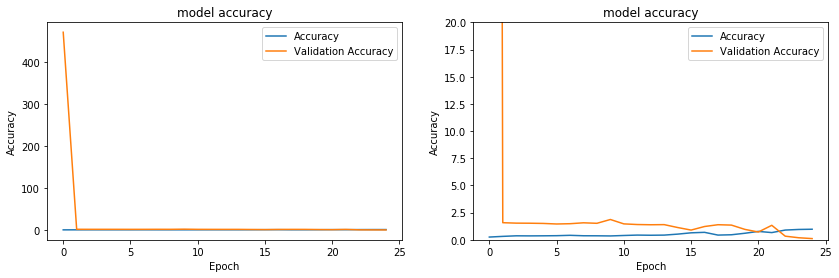

In [18]:
# Plot the coarse and fine versions

fig = plt.figure(figsize=(14,4))

ax1 = fig.add_subplot(1,2,1)

#plt.plot(hist.history["acc"])
ax1.plot(hist.history['accuracy'])
#plt.plot(hist.history['val_acc'])
ax1.plot(hist.history['loss'])
#plt.plot(hist.history['val_loss'])
ax1.set_title("model accuracy")
ax1.set_ylabel("Accuracy")
ax1.set_xlabel("Epoch")
ax1.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])

ax2 = fig.add_subplot(1,2,2)

#plt.plot(hist.history["acc"])
ax2.plot(hist.history['accuracy'])
#plt.plot(hist.history['val_acc'])
ax2.plot(hist.history['loss'])
#plt.plot(hist.history['val_loss'])
ax2.set_title("model accuracy")
ax2.set_ylabel("Accuracy")
ax2.set_xlabel("Epoch")
ax2.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])
ax2.set_ylim(0,20)

In [19]:
# # Plot the coarse and fine versions

# fig = plt.figure(figsize=(14,8))

# ax1 = fig.add_subplot(1,2,1)

# #plt.plot(hist.history["acc"])
# plt.plot(hist.history['accuracy'])
# #plt.plot(hist.history['val_acc'])
# plt.plot(hist.history['loss'])
# #plt.plot(hist.history['val_loss'])
# plt.title("model accuracy")
# plt.ylabel("Accuracy")
# plt.xlabel("Epoch")
# plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])
# plt.show()

In [22]:
# save the model -- this is from my other class
model.save(filepath='vgg16_truck_2_epoch25.h5')

# Predictions

To do predictions on the trained model I need to load the best saved model and pre-process the image and pass the image to the model for output.

In [23]:
saved_model = load_model("vgg16_truck_2_epoch25.h5")

In [24]:
!ls ../images/truck/test

920x920 (1).jpg
New_Orleans_May_2018_Flooding_-_Submerged_Truck.jpg
WALboat-1-AV-800x532.jpg
download.jpeg
maxresdefault (2).jpg
passenger-transport-flooded-thailand-16679421.jpg
sunken-ford-ranger-recovery.jpg
truck.jpg


In [25]:
image_test_dir = '../images/truck/test'

In [26]:
# get files in dir into a list
image_list = os.listdir(image_test_dir)
image_list

['download.jpeg',
 'sunken-ford-ranger-recovery.jpg',
 'passenger-transport-flooded-thailand-16679421.jpg',
 'New_Orleans_May_2018_Flooding_-_Submerged_Truck.jpg',
 '920x920 (1).jpg',
 'maxresdefault (2).jpg',
 'WALboat-1-AV-800x532.jpg',
 'truck.jpg']

In [30]:
if ('.DS_store' in image_list):
    image_list.remove('.DS_Store')
else:
    print("No .DS_Store")

No .DS_Store


In [28]:
image_list

['download.jpeg',
 'sunken-ford-ranger-recovery.jpg',
 'passenger-transport-flooded-thailand-16679421.jpg',
 'New_Orleans_May_2018_Flooding_-_Submerged_Truck.jpg',
 '920x920 (1).jpg',
 'maxresdefault (2).jpg',
 'WALboat-1-AV-800x532.jpg',
 'truck.jpg']

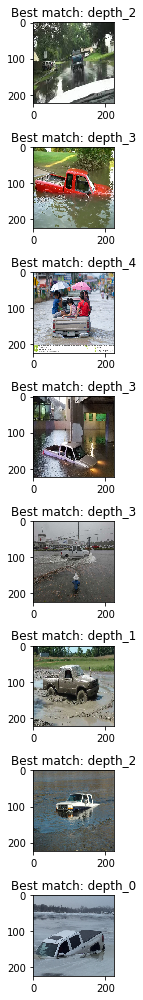

In [29]:
fig = plt.figure(figsize=(14,14))

img_num = 1;
ax_list = []

tot_images = len(image_list)

for img_file in image_list:
    use_image = image_test_dir + '/' + img_file
    ax = fig.add_subplot(tot_images,1,img_num)
    
    
    img = image.load_img(use_image,target_size=(224,224))
    #img = image.load_img("image.jpeg",target_size=(224,224))
    img = np.asarray(img)
    
    plt.imshow(img)
    
    img = np.expand_dims(img, axis=0)
    output = saved_model.predict(img)
    best_match = np.argmax(output)
    #print(f"Best match: {labels[best_match]}")
    title_str = "Best match: " + labels[best_match]
    
    #plt.imshow(img)
    ax.set_title(title_str)
    
    ax_list.append(ax)
    img_num += 1
    
plt.tight_layout()

Here I have loaded the image using image method in keras and converted it to numpy array and added an extra dimension to the image to image for matching NHWC (Number, Height, Width, Channel) format of keras.
This is a complete implementation of VGG16 in keras using ImageDataGenerator. We can make this model work for any number of classes by changing the the unit of last softmax dense layer to whatever number we want based on the classes which we need to classify

Github repo link : https://github.com/1297rohit/VGG16-In-Keras
If you have less amount of data then instead of training your model from scratch you can try Transfer Learning. I have also written a step by step guide for beginners on performing transfer learning on VGG16 using Keras. You can check it out at : https://medium.com/@1297rohit/transfer-learning-from-scratch-using-keras-339834b153b9